<a href="https://colab.research.google.com/github/sunny0103/DeepLearning_nlp_projects/blob/main/KLUE_RE/KLUE_relation_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers  datasets --quiet

In [2]:
import random
import os,gc
from tqdm.notebook import tqdm
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset,  DataLoader

from transformers import (AutoTokenizer,
                          AutoConfig,
                          AdamW,
                          AutoModelForSequenceClassification)

from transformers.optimization import get_cosine_schedule_with_warmup

from datasets import load_dataset

from sklearn.metrics import f1_score, auc, precision_recall_curve, accuracy_score, confusion_matrix

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


seed_everything(42)
SEED = 42

**Label**
* "no_relation",
* "org:dissolved",
* "org:founded",
* "org:place_of_headquarters",
* "org:alternate_names",
* "org:member_of",
* "org:members",
* "org:political/religious_affiliation",
* "org:product",
* "org:founded_by",
* "org:top_members/employees",
* "org:number_of_employees/members",
* "per:date_of_birth",
* "per:date_of_death",
* "per:place_of_birth",
* "per:place_of_death",
* "per:place_of_residence",
* "per:origin",
* "per:employee_of",
* "per:schools_attended",
* "per:alternate_names",
* "per:parents",
* "per:children",
* "per:siblings",
* "per:spouse",
* "per:other_family",
* "per:colleagues",
* "per:product",
* "per:religion",
* "per:title"






In [4]:
dataset = load_dataset("klue", "re", split="train")
split_dataset = dataset.train_test_split(0.2)
train_dataset = split_dataset['train']
valid_dataset = split_dataset['test']
test_dataset = load_dataset("klue", "re", split="validation")

In [5]:
train_dataset

Dataset({
    features: ['guid', 'sentence', 'subject_entity', 'object_entity', 'label', 'source'],
    num_rows: 25976
})

In [6]:
print('guid: ',train_dataset[0]['guid'] )
print('sentence: ',train_dataset[0]['sentence'] )
print('subject_entity: ',train_dataset[0]['subject_entity'] )
print('object_entity: ',train_dataset[0]['object_entity'] )
print('label: ',train_dataset[0]['label'] )
print('source: ',train_dataset[0]['source'] )

guid:  klue-re-v1_train_25570
sentence:  새 섭정은 안티파트로스가 되었으며 두 왕(필리포스 3세와 알렉산드로스 4세)는 마케도니아로 이송되었다.
subject_entity:  {'word': '알렉산드로스 4세', 'start_idx': 32, 'end_idx': 40, 'type': 'PER'}
object_entity:  {'word': '필리포스 3세', 'start_idx': 23, 'end_idx': 29, 'type': 'PER'}
label:  0
source:  wikipedia


In [7]:
valid_dataset

Dataset({
    features: ['guid', 'sentence', 'subject_entity', 'object_entity', 'label', 'source'],
    num_rows: 6494
})

In [8]:
test_dataset

Dataset({
    features: ['guid', 'sentence', 'subject_entity', 'object_entity', 'label', 'source'],
    num_rows: 7765
})

In [9]:
label_list = sorted(list(set(train_dataset[:]['label'])))

In [10]:
MODEL_NAME = "klue/bert-base"

In [11]:
model_config = AutoConfig.from_pretrained(MODEL_NAME)
model_config.num_labels =30

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=model_config)
model.parameters

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<bound method Module.parameters of BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Layer

In [13]:
tokenizer= AutoTokenizer.from_pretrained(MODEL_NAME)

**[CLS] + subject_entity + [SEP] + object_entity + [SEP] + sentence + [SEP]**

In [14]:
def preprocessing_data(examples):
  sep = tokenizer.sep_token
  sub_word = examples['subject_entity']['word']
  obj_word = examples['object_entity']['word']
  concat = sub_word + sep + obj_word
  return {'concat_entity': concat}

In [15]:
train_added = train_dataset.map(preprocessing_data)
valid_added = valid_dataset.map(preprocessing_data)
test_added = test_dataset.map(preprocessing_data)

In [16]:
train_added[0]

{'guid': 'klue-re-v1_train_25570',
 'sentence': '새 섭정은 안티파트로스가 되었으며 두 왕(필리포스 3세와 알렉산드로스 4세)는 마케도니아로 이송되었다.',
 'subject_entity': {'word': '알렉산드로스 4세',
  'start_idx': 32,
  'end_idx': 40,
  'type': 'PER'},
 'object_entity': {'word': '필리포스 3세',
  'start_idx': 23,
  'end_idx': 29,
  'type': 'PER'},
 'label': 0,
 'source': 'wikipedia',
 'concat_entity': '알렉산드로스 4세[SEP]필리포스 3세'}

In [17]:
max_len = 256

class CustomDataset(Dataset):
  def __init__(self, dataset, tokenizer):
    self.dataset = dataset
    self.tokenizer = tokenizer

  def __getitem__(self, index):
    concat_entity = self.dataset[index]['concat_entity']
    sentence = self.dataset[index]['sentence']
    inputs = self.tokenizer(
        concat_entity,
        sentence,
        return_tensors='pt',
        padding='max_length',
        truncation=True,
        max_length=max_len,
        add_special_tokens=True
        )

    input_ids = inputs['input_ids'][0]
    token_type_ids = inputs['token_type_ids'][0]
    attention_mask = inputs['attention_mask'][0]

    label = self.dataset[index]['label']
    return input_ids, token_type_ids, attention_mask, label

  def __len__(self):
    return len(self.dataset)

In [18]:
train_set = CustomDataset(train_added, tokenizer)
valid_set = CustomDataset(valid_added, tokenizer)
test_set = CustomDataset(test_added, tokenizer)

In [19]:
BATCH_SIZE = 32

trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [20]:
# for idx, batch in enumerate(trainloader):
#   print(batch)
#   if idx==0:
#     break

In [21]:
device =  torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [22]:
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
learning_rate =  5e-5

In [23]:
optimizer = AdamW(model.parameters(), lr = learning_rate)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
total_steps = len(trainloader) * num_epochs
warmup_step = int(total_steps * warmup_ratio)

In [25]:
scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_step,
                                            num_training_steps=total_steps)

In [26]:
torch.cuda.empty_cache()
gc.collect()

78

In [27]:
print(label_list.index(0))

0


In [28]:
def klue_re_micro_f1(preds, labels, label_list):
    """KLUE-RE micro f1 (except no_relation)"""
    no_relation_label_idx = label_list.index(0)

    label_indices = list(range(len(label_list)))
    label_indices.remove(no_relation_label_idx)

    return f1_score(labels, preds, average="micro", labels=label_indices) * 100.0

In [29]:
def klue_re_auprc(probs, labels):
    """KLUE-RE AUPRC (with no_relation)"""
    labels = np.eye(30)[labels]
    score = np.zeros((30,))

    for c in range(30):
        targets_c = labels.take([c], axis=1).ravel()
        preds_c = probs.take([c], axis=1).ravel()
        precision, recall, _ = precision_recall_curve(targets_c, preds_c)
        score[c] = auc(recall, precision)

    return np.average(score) * 100.0

In [34]:
def plot_confusion_matrix(c_matrix, labels, title='Confusion Matrix', cmap=plt.colormaps.get_cmap('Blues')):
    plt.figure(figsize=(10,10))
    plt.imshow(c_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    marks = np.arange(len(labels))
    nlabels = []

    for k in range(len(c_matrix)):
        n = sum(c_matrix[k])
        nlabel = '{0}(n={1})'.format(labels[k],n)
        nlabels.append(nlabel)

    # plt.xticks(marks, labels)
    plt.yticks(marks, nlabels)

    thresh = c_matrix.max() / 2.

    for i, j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
      plt.text(j, i, c_matrix[i, j], horizontalalignment="center", color="white" if c_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [35]:
class Trainer():

  def __init__(self, trainloader, validloader, testloader, model, optimizer, scheduler, device):
    self.trainloader= trainloader
    self.validloader = validloader
    self.testloader = testloader
    self.model = model
    self.optimizer = optimizer
    self.scheduler = scheduler
    self.device= device

  def train(self, epochs =1):
    self.model.train()

    for epoch in range(1, epochs+1):
      print('========================Epoch{}/{}========================'.format(epoch, epochs))
      running_loss = 0.0
      for batch in tqdm(self.trainloader):
        batch = tuple(b.to(self.device) for b in batch)
        inputs = {'input_ids': batch[0],
                  'token_type_ids': batch[1],
                  'attention_mask': batch[2],
                  'labels': batch[3]}

        self.optimizer.zero_grad()
        outputs = self.model(**inputs)

        loss = outputs[0]
        running_loss += loss.item()
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        self.optimizer.step()
        self.scheduler.step()

      train_loss = running_loss/len(self.trainloader)
      valid_loss, f1, auprc, acc = self.validate()
      tqdm.write('Train Loss:{:.4f}, Validation Loss:{:.4f}, F1 micro:{:.4f}, AUPRC:{:.4f}, Accuracy:{:.4f}'.
                 format(train_loss, valid_loss, f1, auprc, acc ))

  def validate(self):
    self.model.eval()
    predictions, probs_val , true_vals =[], [], []

    with torch.no_grad():
      running_loss = 0.0
      for batch in tqdm(self.validloader):
        batch = tuple(b.to(self.device) for b in batch)
        inputs = {'input_ids': batch[0],
          'token_type_ids': batch[1],
          'attention_mask': batch[2],
          'labels': batch[3]}

        outputs = self.model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        running_loss += loss.item()

        predicted_label = logits.detach().cpu().numpy().argmax(1)
        probs = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].detach().cpu().numpy()
        predictions.append(predicted_label)
        probs_val.append(probs)
        true_vals.append(label_ids)

      valid_loss = running_loss/len(self.validloader)
      predictions = np.concatenate(predictions, axis=0)
      probs_val = np.concatenate(probs_val, axis=0)
      true_vals = np.concatenate(true_vals, axis=0)

      f1 = klue_re_micro_f1(predictions, true_vals, label_list)
      auprc = klue_re_auprc(probs_val, true_vals)
      acc = accuracy_score(predictions, true_vals)

      return valid_loss, f1, auprc, acc

  def test(self):
    self.model.eval()
    predictions, probs_val, true_vals =[], [], []
    with torch.no_grad():
      for batch in tqdm(self.testloader):
        batch = tuple(b.to(self.device) for b in batch)
        inputs = {'input_ids': batch[0],
                  'token_type_ids': batch[1],
                  'attention_mask': batch[2],
                }

        predict = self.model(**inputs)
        logits = predict[0]
        labels = batch[3]


        predicted_label = logits.detach().cpu().numpy().argmax(1)
        probs = logits.detach().cpu().numpy()
        label_ids = labels.detach().cpu().numpy()
        predictions.append(predicted_label)
        probs_val.append(probs)
        true_vals.append(label_ids)


      predictions = np.concatenate(predictions, axis=0)
      probs_val = np.concatenate(probs_val, axis=0)
      true_vals = np.concatenate(true_vals, axis=0)

      f1 = klue_re_micro_f1(predictions, true_vals, label_list)
      auprc = klue_re_auprc(probs_val, true_vals)
      acc = accuracy_score(predictions, true_vals)
      test_confusion_matrix = confusion_matrix(predictions, true_vals)
      plot_confusion_matrix(test_confusion_matrix, labels=label_list)

      print('Test F1 micro:{:.4f}, AUPRC:{:.4f}, Accuracy:{:.4f}'.format(f1, auprc, acc ))


In [32]:
trainer = Trainer(trainloader= trainloader,
                  validloader = validloader,
                  testloader = testloader,
                  model = model,
                  optimizer = optimizer,
                  scheduler = scheduler,
                  device = device)
trainer.train(epochs=num_epochs)

========================Epoch1/5========================


  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Train Loss:1.2545, Validation Loss:0.6785, F1 micro:79.0909, AUPRC:69.6838, Accuracy:0.7707
========================Epoch2/5========================


  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Train Loss:0.5090, Validation Loss:0.5652, F1 micro:81.9530, AUPRC:75.7592, Accuracy:0.8009
========================Epoch3/5========================


  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Train Loss:0.2553, Validation Loss:0.6479, F1 micro:82.2515, AUPRC:76.2827, Accuracy:0.8034
========================Epoch4/5========================


  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Train Loss:0.0897, Validation Loss:0.8353, F1 micro:82.8016, AUPRC:76.4953, Accuracy:0.8095
========================Epoch5/5========================


  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

Train Loss:0.0276, Validation Loss:0.9005, F1 micro:82.9808, AUPRC:76.4052, Accuracy:0.8103


  0%|          | 0/243 [00:00<?, ?it/s]

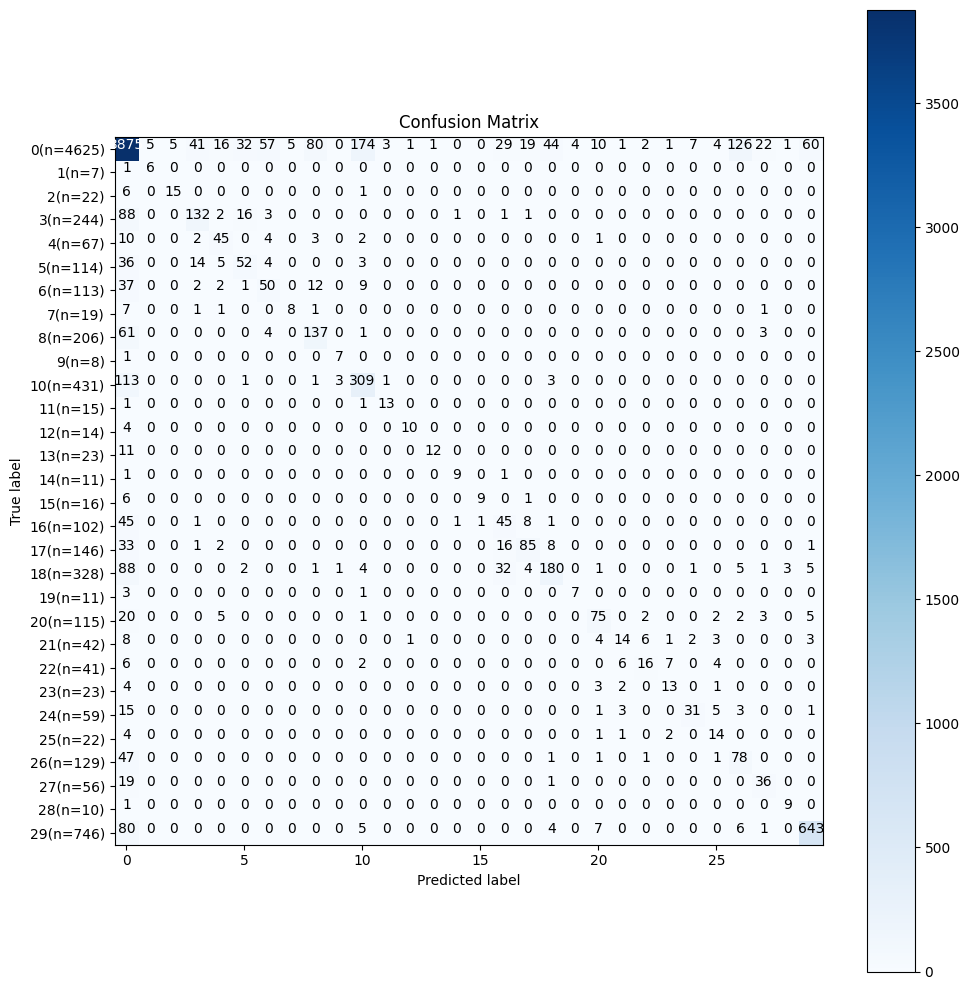

Test F1 micro:65.6678, AUPRC:67.8598, Accuracy:0.7643


In [36]:
trainer.test()